# Visualization of the kernel matrix

This notebook builds a plot of the kernel matrix, broken down by competition.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import thesis

from datetime import datetime
from mpl_toolkits.axes_grid1 import ImageGrid
from peewee import fn
from thesis.playerkern import Game, Actor, init_db, TeamGPModel, TestSet

In [3]:
thesis.setup_plotting()

Thesis settings loaded!


## Load the data

In [4]:
db_path = "data/kdb-2017-11-15-ft-corrected.db"
init_db("sqlite:///{}".format(db_path))

In [5]:
comps = (
    "Primera División",
    "Bundesliga",
    "Premier League",
    "Friendlies",
    "EC Qualification",
    "European Championship",
    "UEFA Champions League",
    "UEFA Europa League",
    "Serie A",
    "Ligue 1",
)

actors = dict((c, list()) for c in comps)
n_games = 0

for comp in comps:
    if comp == "EC Qualification":
        games = Game.select().where((Game.competition == comp)
                & (Game.kickoff_time > datetime(2010, 8, 1))
                & (Game.kickoff_time < datetime(2012, 8, 1))).order_by(fn.Random())
    else:
        games = Game.select().where((Game.competition == comp)
                & (Game.kickoff_time > datetime(2011, 8, 1))
                & (Game.kickoff_time < datetime(2012, 8, 1))).order_by(fn.Random())
    for game in games:
        tmp = set()
        for p in game.participants:
            if p.is_starter:
                tmp.add(p.actor_id)
        n_games += 1
        actors[comp].append(tmp)

print("Total games: {:,}".format(n_games))

Total games: 3,184


## Compute the kernel matrix

In [6]:
%%time

def cov_matrix(actors1, actors2):
    mat = np.zeros((len(actors1), len(actors2)))
    for i, set1 in enumerate(actors1):
        for j, set2 in enumerate(actors2):
            mat[i, j] = any(set1.intersection(set2))
    return mat

covs = np.zeros((len(comps), len(comps)), dtype=object)
for i, comp1 in enumerate(comps):
    for j, comp2 in enumerate(comps):
        covs[i, j] = cov_matrix(actors[comp1], actors[comp2])

CPU times: user 9.4 s, sys: 50.5 ms, total: 9.45 s
Wall time: 9.45 s


## Plot it

In [7]:
labels = [
    "La Liga",
    "Bundesliga",
    "Premier League",
    "Friendlies",
    "Euro Qualifications",
    "Euro Championship",
    "Champions League",
    "Europa League",
    "Serie A",
    "Ligue 1",
]

 /Users/maystre/.virtualenvs/thesis/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
 /Users/maystre/.virtualenvs/thesis/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
 /Users/maystre/.virtualenvs/thesis/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


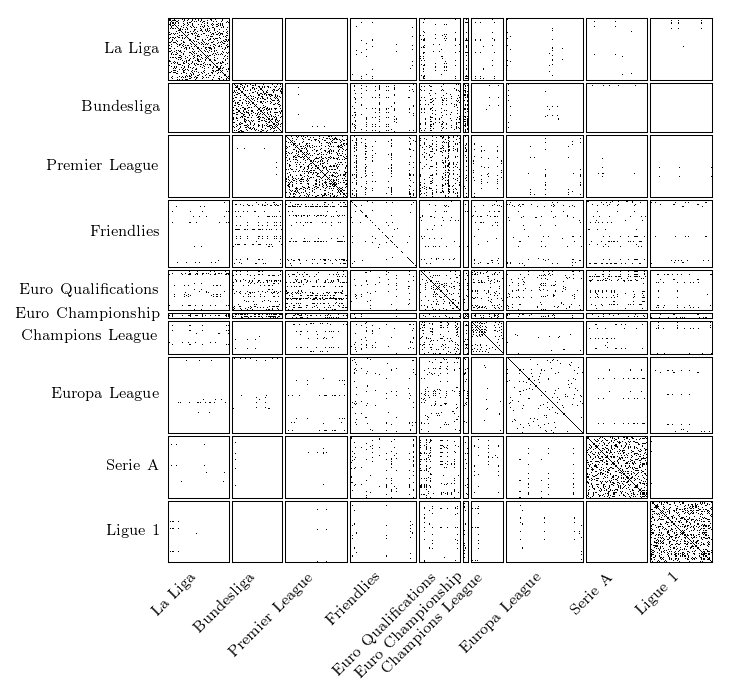

In [8]:
fig = plt.figure(figsize=(5.0, 5.0))
grid = ImageGrid(fig, 111, nrows_ncols=(len(comps), len(comps)), axes_pad=0.02, add_all=True)
plt.rcParams["axes.linewidth"] =0.1

cmap = plt.get_cmap("binary")

for i in range(len(comps)):
    for j in range(len(comps)):
        ax = grid[i*len(comps) + j]
        img = ax.imshow(covs[i,j], cmap=cmap)
        img.set_rasterized(True)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_ylabel(labels[i], rotation=0, ha="right", va="center", fontsize=7.0)
        if i == len(comps)-1:
            ax.set_xlabel(labels[j], rotation=45, ha="right", va="top", fontsize=7.0)
    
fig.savefig("kernel-matrix.pdf", dpi=300)